*Note*:
# **Before running Jupyter Notebook, please add processed_crime_dataset.csv and Neighbourhoods.geojson into the files (alter file paths in the code accordingly).**

# Imports

In [ ]:
#Import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import InputLayer
from keras.layers import Dropout
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import shutil
import geopandas

import warnings
warnings.filterwarnings('ignore')

#Initial Data Analysis

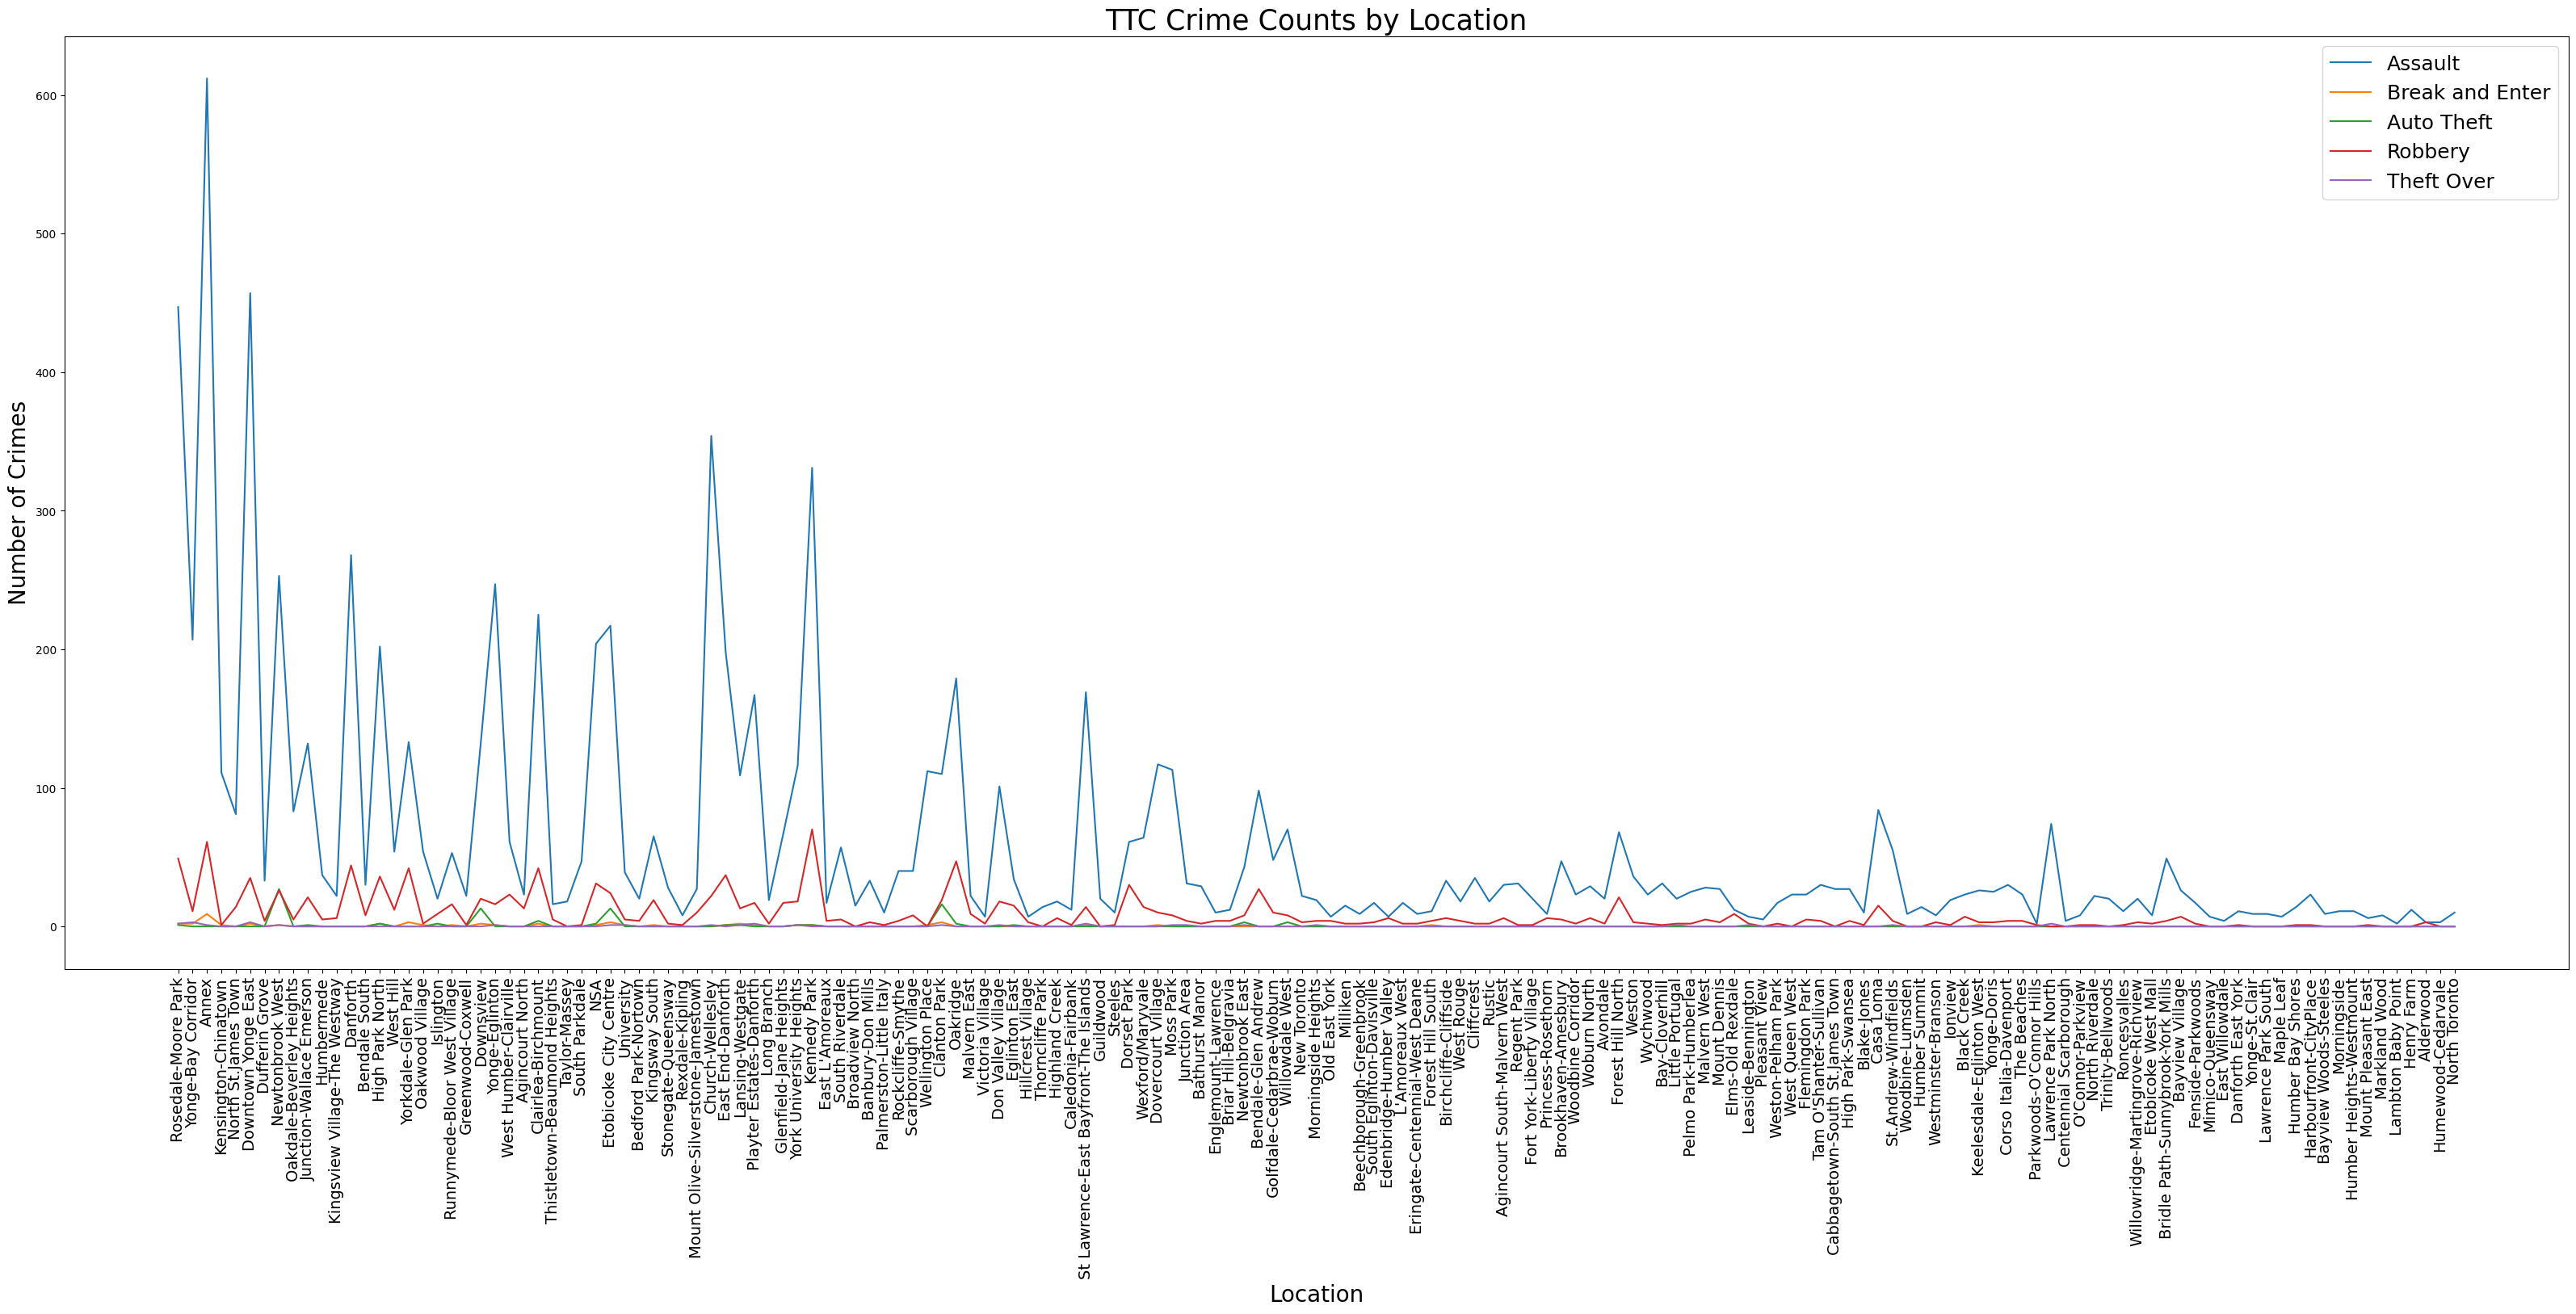

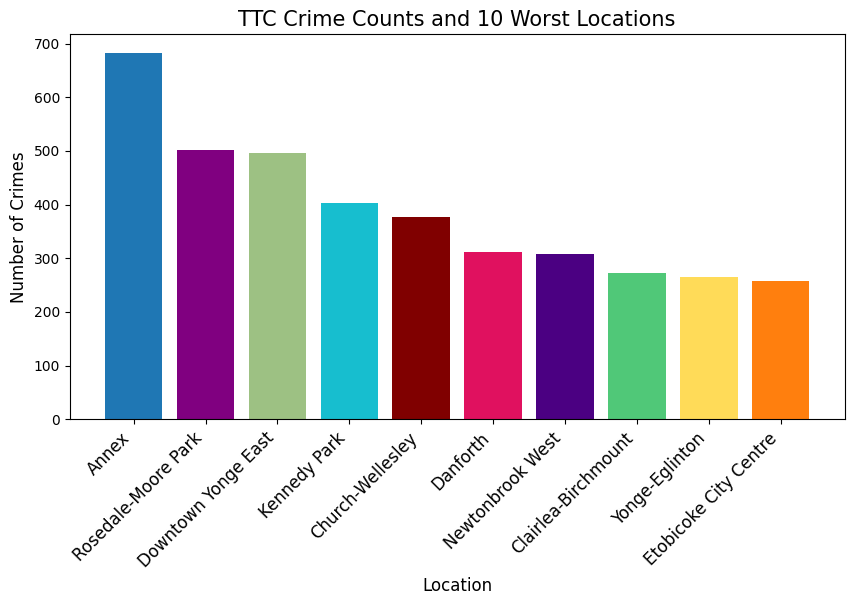

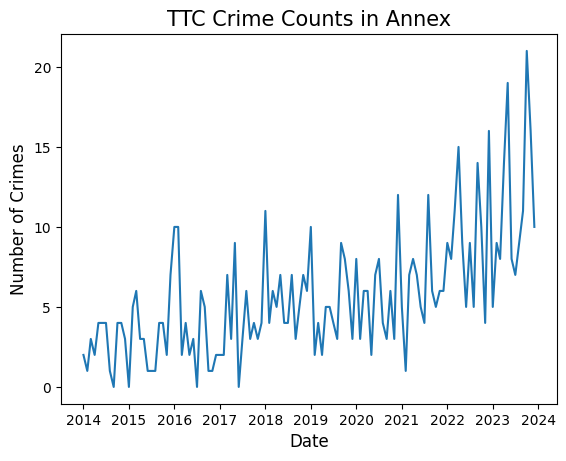

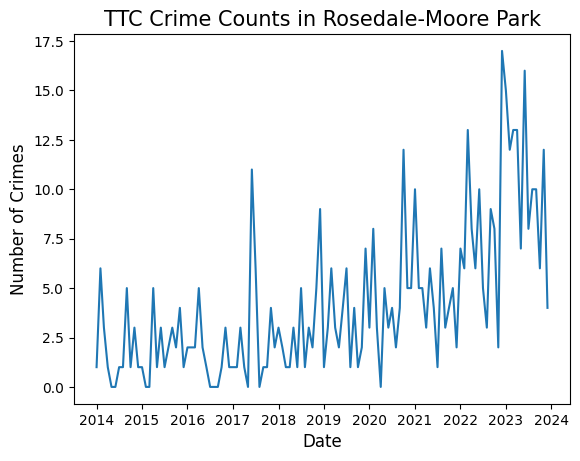

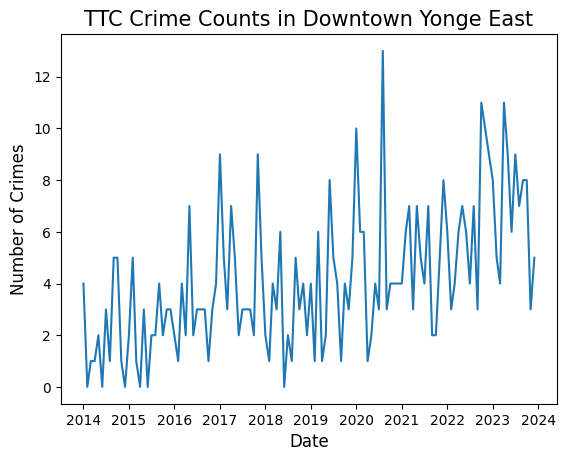

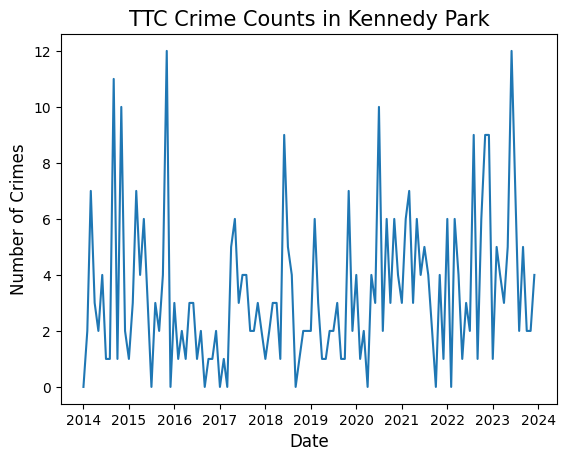

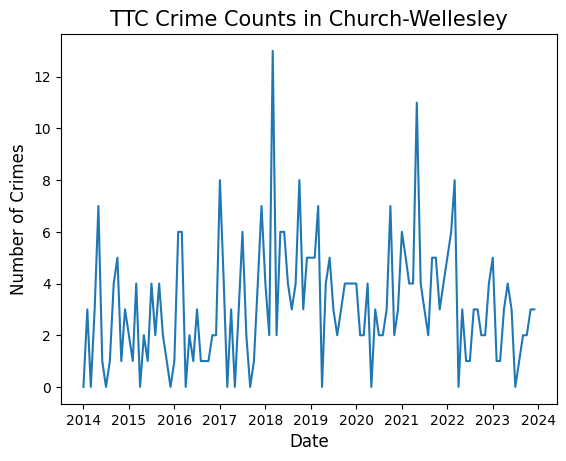

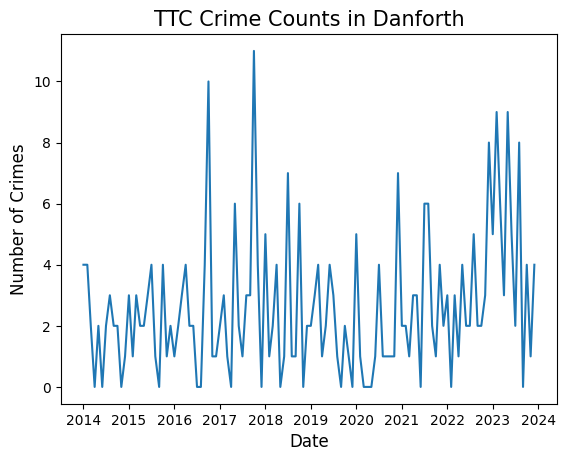

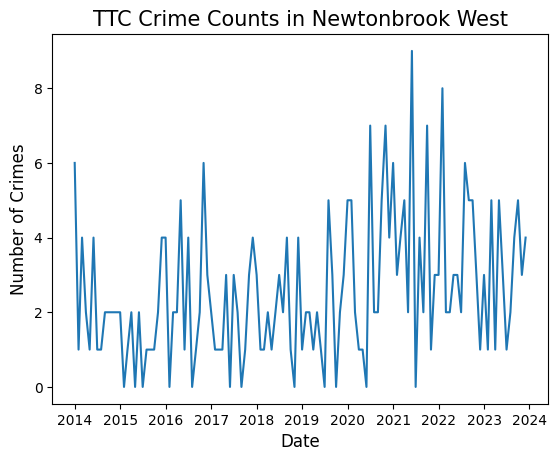

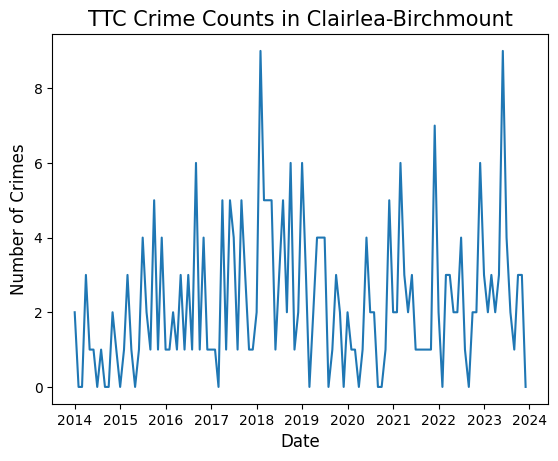

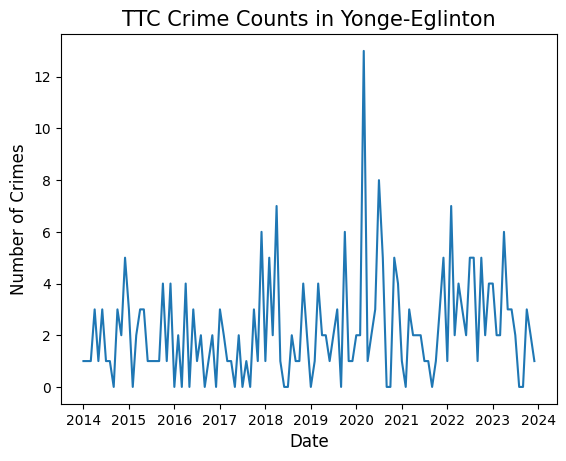

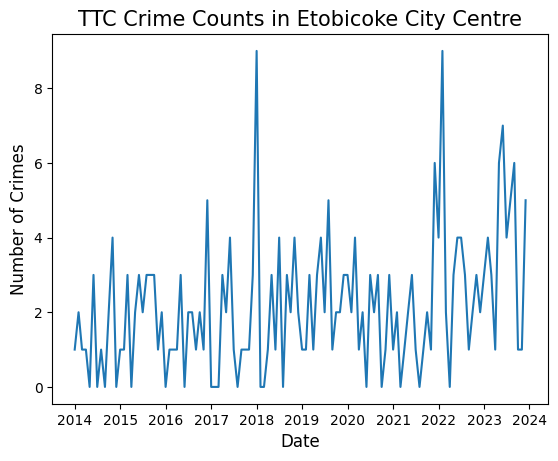

In [ ]:
#Data
data_df = pd.read_csv('/content/processed_crime_dataset.csv')
data_df = data_df.drop('Unnamed: 0', axis=1) #column added in csv is removed
#There are about 11000 rows in data_df
#Convert OCC_DATE to datetime
data_df['OCC_DATE'] = pd.to_datetime(data_df['OCC_DATE'])
data_df['OCC_DATE'] = data_df['OCC_DATE'].dt.strftime('%Y/%m')


#There are 5 MCI Categories (https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-open-data/about)
mci_crime_types = ['Assault', 'Break and Enter', 'Auto Theft', 'Robbery', 'Theft Over', 'Total']

#Create a dictionary with locations as key, list with crime types as value.
all_locations = data_df['NEIGHBOURHOOD_158'].unique()
location_crime_dict = {}

for location in all_locations:
  location_crime_dict[location] = [0,0,0,0,0]

for index, row in data_df.iterrows():
  temp = 0
  location = row['NEIGHBOURHOOD_158']
  crime = row['MCI_CATEGORY']
  if crime == 'Assault':
    location_crime_dict[location][0] = location_crime_dict[location][0] + 1
  elif crime == 'Break and Enter':
    location_crime_dict[location][1] = location_crime_dict[location][1] + 1
  elif crime == 'Auto Theft':
    location_crime_dict[location][2] = location_crime_dict[location][2] + 1
  elif crime == 'Robbery':
    location_crime_dict[location][3] = location_crime_dict[location][3] + 1
  elif crime == 'Theft Over':
    location_crime_dict[location][4] = location_crime_dict[location][4] + 1

# Extracting location names and counts
locations = list(location_crime_dict.keys())
counts = list(location_crime_dict.values())

# Plotting
plt.figure(figsize=(40, 15))

# Plot each MCI crime with a different line
for i in range(5):
    crime_counts = [count[i] for count in counts]
    plt.plot(locations, crime_counts, label=mci_crime_types[i])

plt.xlabel('Location', fontsize=20)
plt.ylabel('Number of Crimes', fontsize=20)
plt.title('TTC Crime Counts by Location', fontsize=25)
plt.legend(fontsize=18)
plt.xticks(rotation=90, fontsize=14)  #Rotate label on X-axis by 90 degrees
plt.show()

total_crime_counter = Counter()

for k, v in location_crime_dict.items():
  total_crime_counter[k] = sum(v)

top_10 = total_crime_counter.most_common(10)

top_10_locations = []
top_10_rates = []
for k, v in top_10:
  top_10_locations.append(k)
  top_10_rates.append(v)

#Plotting this as a graph:
plt.figure(figsize=(10, 5))
plt.bar(top_10_locations, top_10_rates, color=['#1f77b4','purple','#9DC183','#17becf','#800000','#E0115F','#4B0082','#50C878','#FFDB58','#ff7f0e'])
plt.xlabel('Location', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.title('TTC Crime Counts and 10 Worst Locations', fontsize=15)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()


all_crimes_df = data_df
all_crimes_df = all_crimes_df.groupby(['OCC_DATE', 'NEIGHBOURHOOD_158']).size().reset_index(name='COUNT')

locations_lst = []
for location in top_10_locations: #For each neighbourhood in most dangerous neighbourhoods
  location_df = all_crimes_df[all_crimes_df['NEIGHBOURHOOD_158']==location]

  start_date = pd.to_datetime('2014-01')
  end_date = pd.to_datetime('2024-01')

  #Following 4 lines are altered code from https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
  idx = pd.date_range(start=start_date, end=end_date, freq='M').strftime('%Y/%m')
  s = pd.Series(location_df['COUNT'].values, index=location_df['OCC_DATE'])
  s.index = pd.DatetimeIndex(s.index)
  s = s.reindex(idx, fill_value=0)

  location_df = pd.DataFrame(s)
  location_df.reset_index(inplace=True)
  location_df.columns = ['OCC_DATE', 'COUNT']
  location_df['OCC_DATE'] = pd.to_datetime(location_df['OCC_DATE'])
  locations_lst.append((location,location_df))

  #Plotting the data
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('Number of Crimes', fontsize=12)
  plt.title('TTC Crime Counts in {}'.format(location), fontsize=15)
  plt.plot(location_df['OCC_DATE'], location_df['COUNT'])
  plt.show()


processed_cc = []
for i in range(len(locations_lst)):
  #Create temp df of date, count, location
  df = locations_lst[i][1]
  df['NEIGHBOURHOOD_158'] = locations_lst[i][0]

  #Append temp dfs to a list
  processed_cc.append(df)

#Concatonate dfs of each location to get list with date, count, location for top 10 neightbourhoods:
processed_cc_df = pd.concat(processed_cc)


In [ ]:
#Create a dictionary to store future predictions for each of the 10 locations
future_crime_predictions = {} #Stores location:list of predicitions for next 12 months
for location in top_10_locations:
  future_crime_predictions[location] = []
print(future_crime_predictions)

{'Annex': [], 'Rosedale-Moore Park': [], 'Downtown Yonge East': [], 'Kennedy Park': [], 'Church-Wellesley': [], 'Danforth': [], 'Newtonbrook West': [], 'Clairlea-Birchmount': [], 'Yonge-Eglinton': [], 'Etobicoke City Centre': []}


#Implementing RNN

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_13 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable params: 249665 (975.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Please hold wh

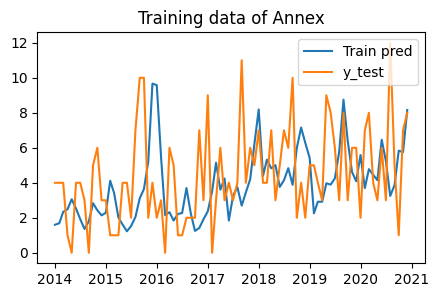

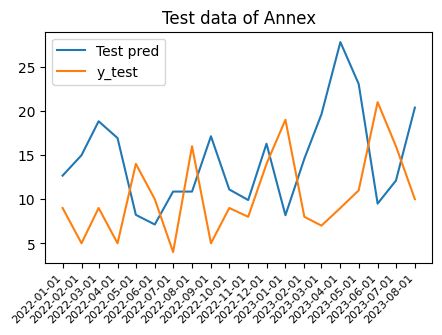

1/1 [==============================] - 0s 22ms/step
Annex :  [20.37511, 32.238346, 48.032608, 49.75111, 79.56615, 126.60688]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_16 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable params: 249665 (97

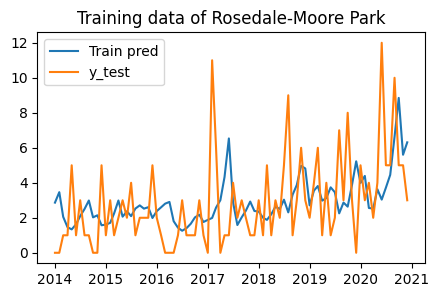

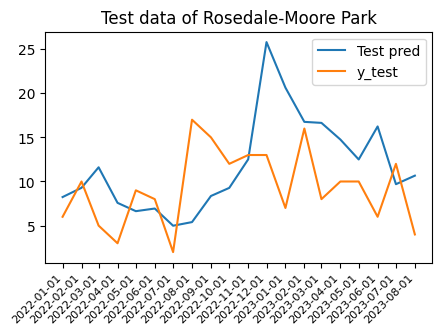

1/1 [==============================] - 0s 27ms/step
Rosedale-Moore Park :  [10.661641, 10.317072, 10.2641535, 14.284799, 13.457763, 14.734772]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_19 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable 

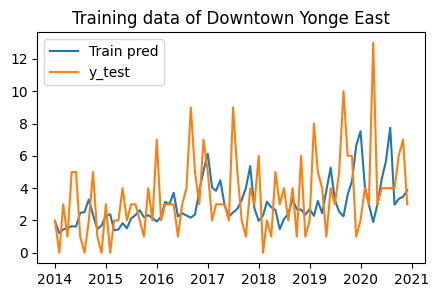

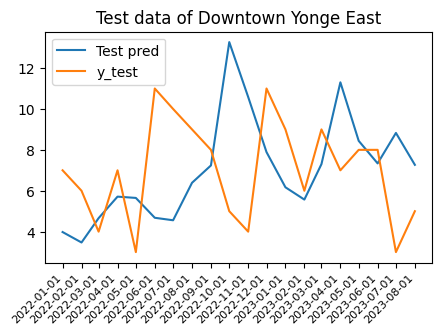

1/1 [==============================] - 0s 33ms/step
Downtown Yonge East :  [7.2674146, 6.9355674, 5.7423396, 4.580915, 6.443344, 5.5984015]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_22 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable par

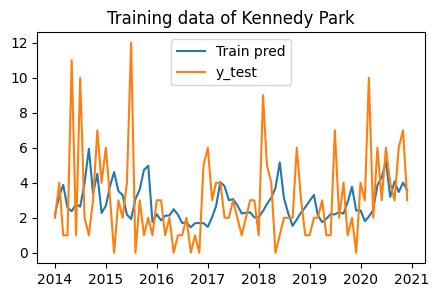

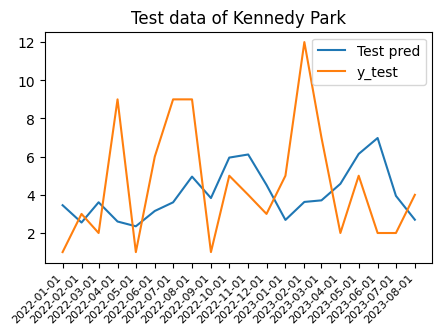

1/1 [==============================] - 0s 23ms/step
Kennedy Park :  [2.6967804, 2.9872408, 2.252153, 2.3769865, 2.5430832, 2.5047607]
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_25 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_26 (LSTM)              (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable params: 2

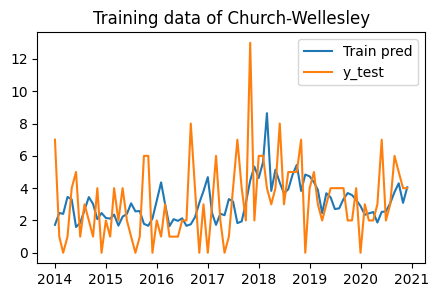

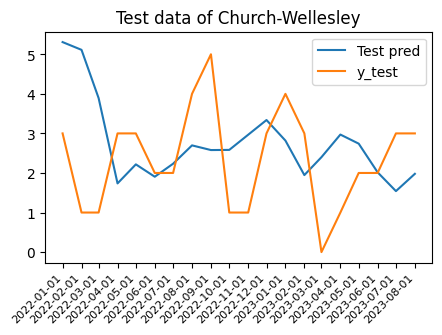

1/1 [==============================] - 0s 22ms/step
Church-Wellesley :  [1.9782581, 2.313903, 2.4100032, 2.5363016, 2.32637, 2.4474213]
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_28 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable params:

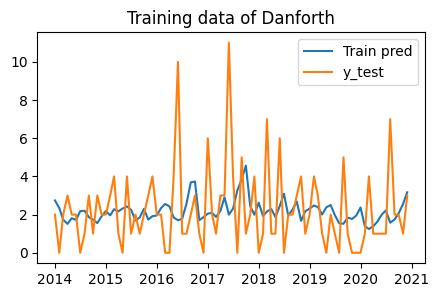

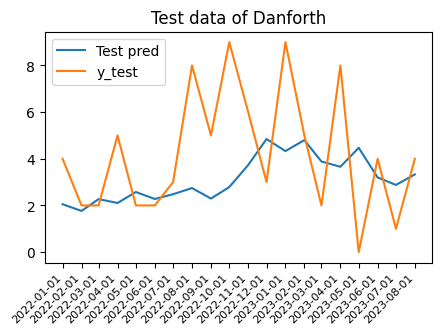

1/1 [==============================] - 0s 21ms/step
Danforth :  [3.3304963, 1.8867874, 2.439113, 2.0105329, 2.3461409, 2.0808852]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_31 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_32 (LSTM)              (None, 64)                49408     
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable params: 2496

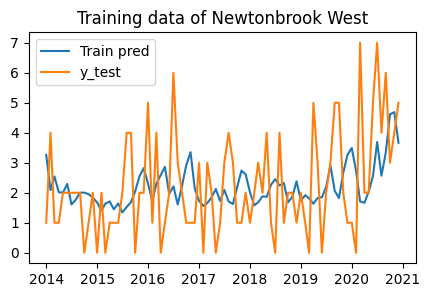

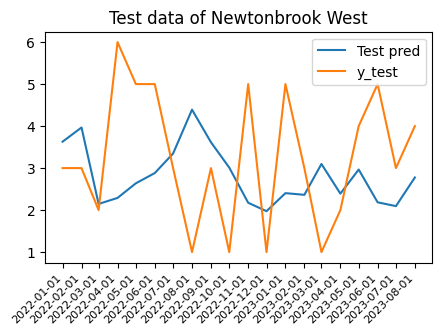

1/1 [==============================] - 0s 22ms/step
Newtonbrook West :  [2.7767463, 3.347373, 3.2084117, 2.6112034, 2.61947, 2.68674]
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_34 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_35 (LSTM)              (None, 64)                49408     
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable params: 

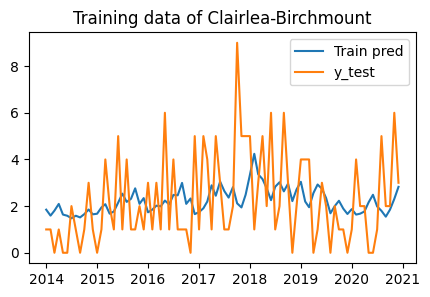

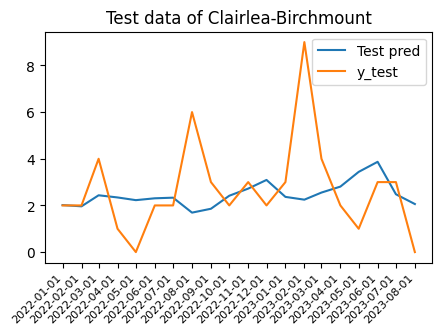

1/1 [==============================] - 0s 21ms/step
Clairlea-Birchmount :  [2.0601041, 2.099064, 2.4403524, 2.3154716, 2.1493158, 2.1908739]
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_37 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_38 (LSTM)              (None, 64)                49408     
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable p

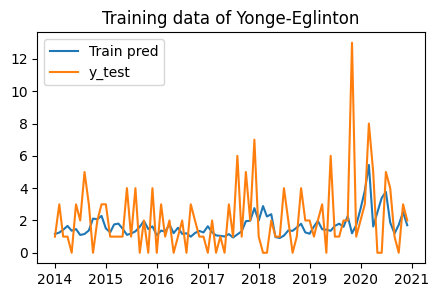

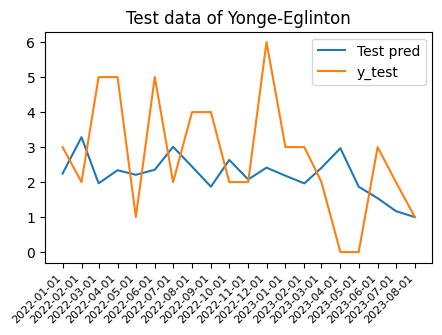

1/1 [==============================] - 0s 21ms/step
Yonge-Eglinton :  [1.0006661, 1.2588928, 1.6497979, 1.3289963, 1.1944671, 1.2647951]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 4, 128)            66560     
                                                                 
 lstm_40 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_41 (LSTM)              (None, 64)                49408     
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 249665 (975.25 KB)
Trainable param

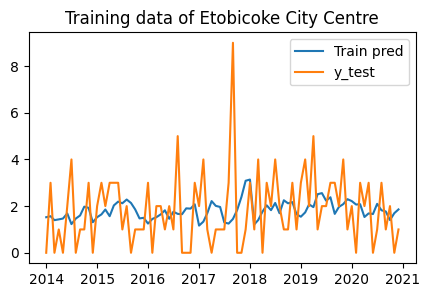

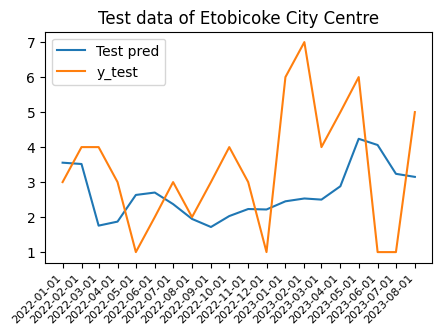

1/1 [==============================] - 0s 22ms/step
Etobicoke City Centre :  [3.1490984, 2.5853546, 1.6081469, 1.838897, 2.1479595, 1.9023151]


In [ ]:
for location in top_10_locations:
  #location = "Rosedale-Moore Park"
  RNN_df = processed_cc_df[processed_cc_df['NEIGHBOURHOOD_158']==location]
  RNN_df.drop(columns=['NEIGHBOURHOOD_158'],inplace=True)
  RNN_df.set_index('OCC_DATE', inplace=True)
  RNN_df.index = pd.to_datetime(RNN_df.index, format='%Y-%m-%d')

  #First lets split the data into batches that the RNN can use:

  RNN_np = RNN_df.values
  input_length = 4 #4 is the best length

  batches_generator = TimeseriesGenerator(RNN_np, RNN_np, length = input_length, batch_size=1)

  #Split dataset into X and y
  X = []
  y = []

  # Iterate over all batches generated by the generator
  for i in range(len(batches_generator)):
      X_batch, y_batch = batches_generator[i]
      y.append(np.squeeze(y_batch).tolist())
      X.append([np.squeeze(X_batch).tolist()])

  X = np.array(X)
  X = X.reshape(X.shape[0], X.shape[2], X.shape[1])
  y = np.array(y)

  #Split into train, validate and test
  RNN_df_len = len(RNN_df)

  X_train = X[:int(RNN_df_len*0.7)]
  y_train = y[:int(RNN_df_len*0.7)]
  X_validate = X[int(RNN_df_len*0.7):int(RNN_df_len*0.7)+int(RNN_df_len*0.1)]
  y_validate = y[int(RNN_df_len*0.7):int(RNN_df_len*0.7)+int(RNN_df_len*0.1)]
  X_test = X[int(RNN_df_len*0.7)+int(RNN_df_len*0.1):]
  y_test = y[int(RNN_df_len*0.7)+int(RNN_df_len*0.1):]

  #Try adding some dropout layers
  model = Sequential()
  model.add(InputLayer((input_length,1)))
  model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(input_length, 1))) #was 128
  model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(input_length, 128))) #was 128
  model.add(LSTM(64, activation='relu'))#--> was 128
  model.add(Dense(32))
  model.add(Dense(1))
  directory = '/content/model1'
  if os.path.exists(directory):
      shutil.rmtree(directory)

  callback_val = ModelCheckpoint('/content/model1', save_best_only=True)
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  print("Please hold while the model is learning!! ... ")

  model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=15, callbacks=[callback_val]) #epoch changed from 50 --> 25 -->15.      15 epochs isn't bad

  model = load_model('/content/model1')

  RNN_df = RNN_df.reset_index()
  dates_index = RNN_df['OCC_DATE']
  train_dates = dates_index[:int(RNN_df_len*0.7)]
  validate_dates = dates_index[int(RNN_df_len*0.7):int(RNN_df_len*0.7)+int(RNN_df_len*0.1)]
  test_dates = dates_index[int(RNN_df_len*0.7)+int(RNN_df_len*0.1):]

  train_predictions = model.predict(X_train).flatten()
  train_pred = pd.DataFrame(data={'Train pred': train_predictions, "y_train": y_train})
  train_pred['OCC_DATE'] = train_dates
  train_pred.set_index('OCC_DATE', inplace=True)

  test_predictions = model.predict(X_test).flatten()
  test_pred = pd.DataFrame(data={'Test pred': test_predictions, "y_test": y_test})
  test_dates = test_dates[:-4]
  test_pred['OCC_DATE'] = test_dates.values
  test_pred.set_index('OCC_DATE', inplace=True)

  #Evaluate MSE:
  mse = mean_squared_error(y_train, train_predictions)
  print("Mean Squared Error:", mse)


  #Graphing Training Data
  plt.figure(figsize=(5, 3))
  plt.title("Training data of " + location)
  plt.plot(train_pred['Train pred'], label='Train pred')
  plt.plot(train_pred['y_train'], label='y_test')
  plt.legend()
  plt.show()

  #Graphing Test Data
  plt.figure(figsize=(5, 3))
  plt.plot(test_pred['Test pred'], label='Test pred')
  plt.plot(test_pred['y_test'], label='y_test')
  plt.title("Test data of " + location)
  plt.xticks(test_pred.index, rotation=45, fontsize=8, ha='right')
  plt.legend()
  plt.show()

  #Make future predicitons
  future_predictions = [] #Lst used to store predictions for the current location being considered.

  future_pred_batch = X_test[-1] #I.e. the final window in test data
  future_pred_batch = future_pred_batch.astype(float)

  #Reshape so it can go into RNN:
  future_pred_batch = future_pred_batch.reshape(1,4,1)

  for i in range(6):
    #****
    pred = model.predict(future_pred_batch) #Make prediciton
    pred = pred[0,0] #Get numerical value from numpy array
    future_predictions.append(pred) #Add predicition to prediction list
    #Now update the batch to take out oldest value and include this value instead:
    future_pred_batch = np.append(future_pred_batch, np.array([[[pred]]]), axis=1) #Append new value to batch
    future_pred_batch = np.delete(future_pred_batch, [0,0,0], axis=1) #update batch (i.e. delete oldest value)

  print(location, ": ", future_predictions)
  future_crime_predictions[location] = future_predictions



# Generating Heatmap for Future Predictions

In [6]:
print(future_crime_predictions)

{'Annex': [20.37511, 32.238346, 48.032608, 49.75111, 79.56615, 126.60688], 'Rosedale-Moore Park': [10.661641, 10.317072, 10.2641535, 14.284799, 13.457763, 14.734772], 'Downtown Yonge East': [7.2674146, 6.9355674, 5.7423396, 4.580915, 6.443344, 5.5984015], 'Kennedy Park': [2.6967804, 2.9872408, 2.252153, 2.3769865, 2.5430832, 2.5047607], 'Church-Wellesley': [1.9782581, 2.313903, 2.4100032, 2.5363016, 2.32637, 2.4474213], 'Danforth': [3.3304963, 1.8867874, 2.439113, 2.0105329, 2.3461409, 2.0808852], 'Newtonbrook West': [2.7767463, 3.347373, 3.2084117, 2.6112034, 2.61947, 2.68674], 'Clairlea-Birchmount': [2.0601041, 2.099064, 2.4403524, 2.3154716, 2.1493158, 2.1908739], 'Yonge-Eglinton': [1.0006661, 1.2588928, 1.6497979, 1.3289963, 1.1944671, 1.2647951], 'Etobicoke City Centre': [3.1490984, 2.5853546, 1.6081469, 1.838897, 2.1479595, 1.9023151]}


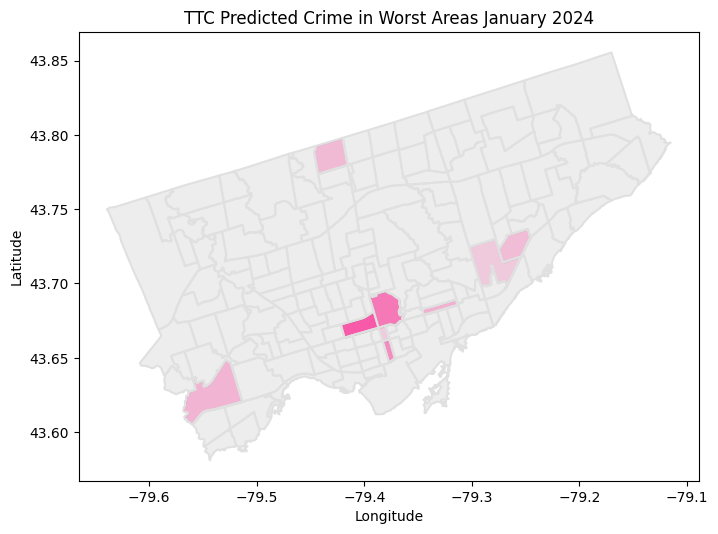

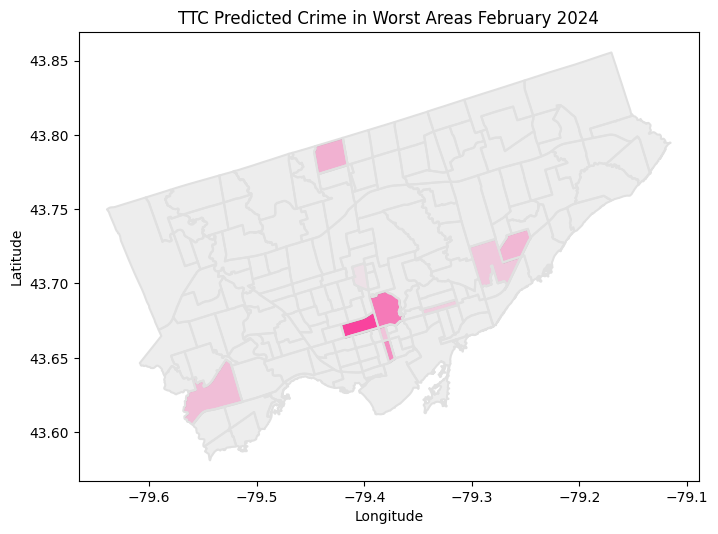

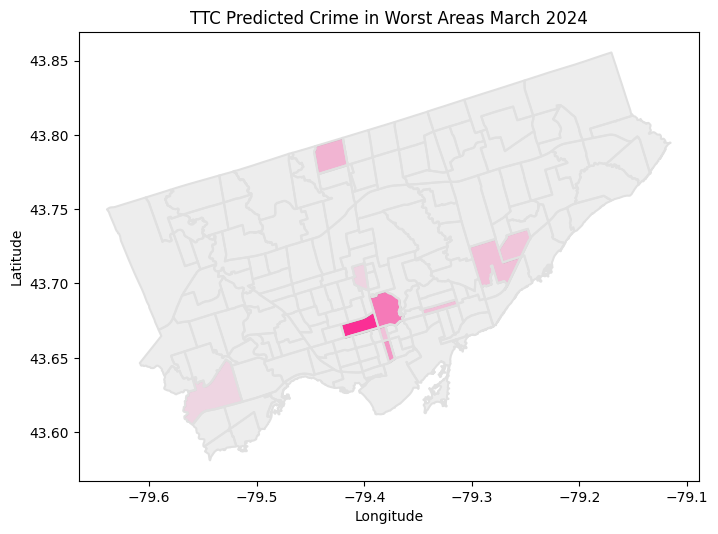

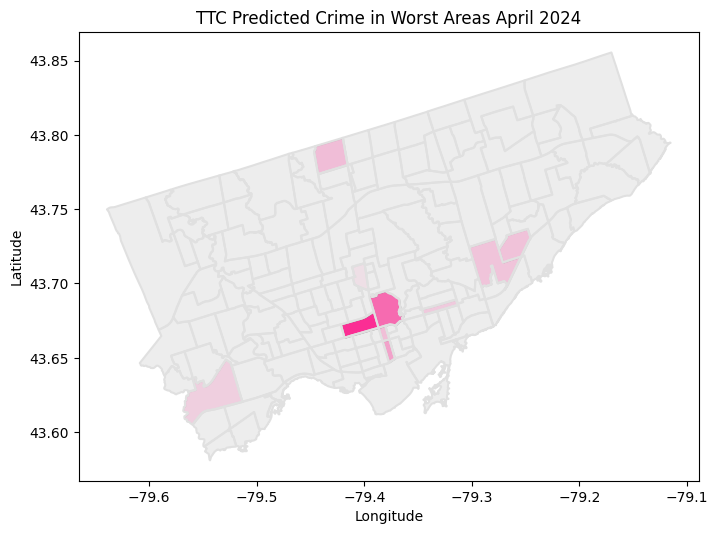

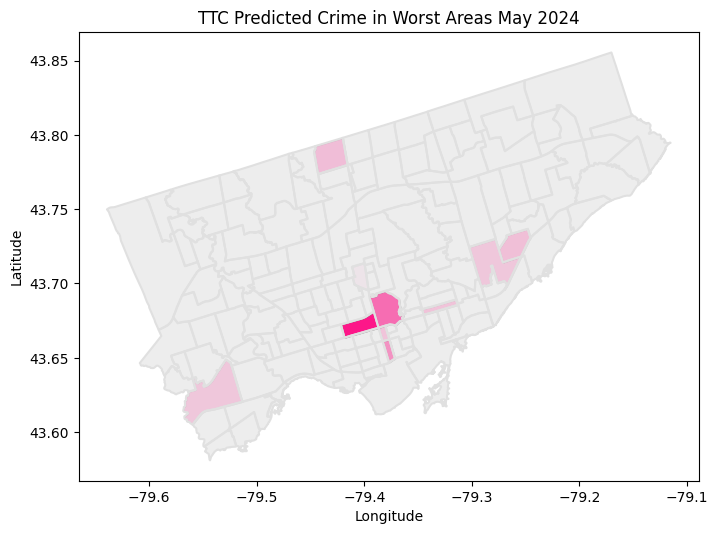

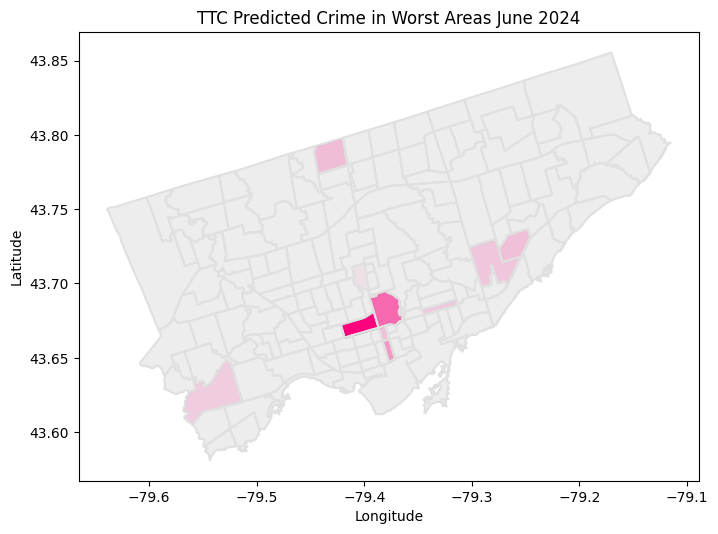

In [8]:
location_crime_dict = future_crime_predictions

months = ["January 2024", "February 2024", "March 2024", "April 2024", "May 2024", "June 2024"]
max_count = 0
for location in location_crime_dict:
  temp_max = max(location_crime_dict[location])
  max_count = max(max_count, temp_max)

# Load the geojson file
neighborhoods = geopandas.read_file("/content/Neighbourhoods.geojson")

for i in range(len(months)):
  fig, ax = plt.subplots(figsize=(8, 6)) #Fig is figure object and ax is the graph that we're using
  neighborhoods.plot(ax=ax, color='#ededed') #Shading background of the graph
  neighborhoods.boundary.plot(ax=ax, color='#e0e0e0') #Adding border lines to neighbourhoods
  #max_val = max(location_crime_dict.values()) #Create a set with all values, take the max of it

  for neighbourhood_name, count in location_crime_dict.items():
      neighbourhood = neighborhoods[neighborhoods['AREA_NAME'] == neighbourhood_name]
      #shading = count[i] / max_count
      shading = np.log10(count[i])/np.max(np.log10(max_count)) #Some alues dominante so use log to scale them
      if shading < 0:
        shading = 0
      neighbourhood.plot(ax=ax, color='#FF007F', edgecolor='0.5', alpha=shading) #Add the neighbourhood with shading to th emap

  plt.title('TTC Predicted Crime in Worst Areas {}'.format(months[i]))
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.show()


#Graphing Future Predictions

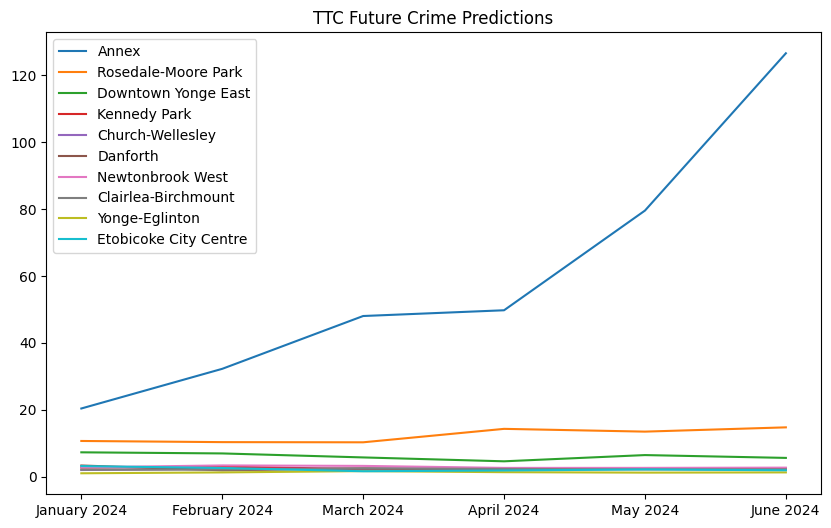

In [9]:
"""
#Create indexes for the future 6 dates (i.e. January 2024 - June 2024)
start_future_date = pd.to_datetime('2024-01')
end_future_date = pd.to_datetime('2024-07')

future_indexes = months#pd.date_range(start=start_future_date, end=end_future_date, freq='M').strftime('%Y/%m')#Generating future dates
#future_indexes = pd.to_datetime(future_indexes)
future_indexes_df = pd.DataFrame()
future_indexes_df["Future Indexes"] = months#future_indexes
future_indexes_df = future_indexes_df.set_index(months)
"""
x = np.array(range(len(months)))




plt.figure(figsize=(10, 6))
plt.plot(location_crime_dict["Annex"], label='Annex')
plt.plot(location_crime_dict["Rosedale-Moore Park"], label='Rosedale-Moore Park')
plt.plot(location_crime_dict["Downtown Yonge East"], label='Downtown Yonge East')
plt.plot(location_crime_dict["Kennedy Park"], label='Kennedy Park')
plt.plot(location_crime_dict["Church-Wellesley"], label='Church-Wellesley')
plt.plot(location_crime_dict["Danforth"], label='Danforth')
plt.plot(location_crime_dict["Newtonbrook West"], label='Newtonbrook West')
plt.plot(location_crime_dict["Clairlea-Birchmount"], label='Clairlea-Birchmount')
plt.plot(location_crime_dict["Yonge-Eglinton"], label='Yonge-Eglinton')
plt.plot(location_crime_dict["Etobicoke City Centre"], label='Etobicoke City Centre')
plt.title("TTC Future Crime Predictions")
plt.xticks(x, months)
plt.legend()
plt.show()




#Resources for Implementation


In [ ]:
#Resources (for RNN/LSTM):
#https://www.youtube.com/watch?v=Mdp5pAKNNW4
#https://www.youtube.com/watch?v=97bZKO6cJfg&t=781s
#https://www.youtube.com/watch?v=442BTP1_ZBw
#https://github.com/bnsreenu/python_for_microscopists/blob/master/166b_COVID_forecasting_using_LSTM.py
#https://github.com/bnsreenu/python_for_microscopists/blob/master/166a-Intro_to_time_series_Forecasting_using_LSTM.py
#https://github.com/bnsreenu/python_for_microscopists
#https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
#https://www.geeksforgeeks.org/python-removing-first-element-of-list/#:~:text=Use%20the%20numpy.,the%20original%20and%20modified%20lists
#https://www.geeksforgeeks.org/using-numpy-to-convert-array-elements-to-float-type/
#https://www.reddit.com/r/learnprogramming/comments/oltnih/periods_added_after_array_entries_when_splitting/?rdt=54314
#https://stackoverflow.com/questions/3100985/plot-with-custom-text-for-x-axis-points

##Resources (for heatmap):
#https://geopandas.org/en/stable/docs/user_guide/io.html
#https://geopandas.org/en/stable/docs/user_guide/mapping.html
#https://www.youtube.com/watch?v=2isVrKpAx6Q
#https://nbviewer.org/gist/perrygeo/c426355e40037c452434
#https://python-graph-gallery.com/map-read-geojson-with-python-geopandas/
#https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
#https://www.youtube.com/watch?v=qxO8egwNtG0&t=264s&ab_channel=RyanNoonan
#https://stackoverflow.com/questions/62213527/setting-color-of-area-in-matplotlib

#Resources (for datasets)
# https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-open-data/about
# https://open.toronto.ca/dataset/neighbourhoods/